In [1]:
import helper
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import random as rd
from multiprocessing import Pool

In [2]:
#goal simulate labeling patterns

n=100
c13ab = 0.011 #natural abundance
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2] #get expected labeling of precursor from natural abundance
isa_func = helper.palmitateISA

gs = np.random.random(n)
xs = np.array([x/np.sum(x) for x in np.random.random((n,3))])
T = [0,0,1]
noiseFrac = .00
numCores = 20

In [3]:
labeling_theo = []
for g,x in zip(gs,xs):
    labeling_theo.append(isa_func(g,1,x,N,None))
labeling_theo = np.array(labeling_theo)

In [ ]:
if __name__ == "__main__":
    r2_dict = {}
    for noiseFrac in np.linspace(0,1,10):

        g_preds = []
        x_preds = []
        x_trues = []
        l_preds = []
        l_observed = []
        l_theo = []
        args = []
        for g,x,l_true in zip(gs,xs,labeling_theo):
            noise = np.random.random(l_true.shape)
            noise = noiseFrac * noise / np.sum(noise)
            l_obs = [l+ns for l,ns in zip(l_true,noise)]
            l_obs = np.array(l_obs)/np.sum(l_obs)

            x_trues += list(x)
            args.append((T,N,l_obs,16,list(range(len(l_obs))),[.5,.1,.1,.1,.1]))

        pool = Pool(numCores)
        results = pool.starmap(helper.ISAFit_nonSS_full,args)
        pool.close()
        pool.join()

        for g_pred, _, x_pred, err, l_pred in results:
            if g_pred < -.1 or g_pred > 1.1 or any(xx < -.1 or xx > 1.1 for xx in x_pred):
                g_pred = 0
                x_pred = [0,0,1]
            g_preds.append(g_pred)
            x_preds += list(x_pred)
            l_preds += list(l_pred)
            l_observed += list(l_obs)
            l_theo += list(l_true)

        r2_dict[noiseFrac] = {}

        r2_dict[noiseFrac]["g"] = r2_score(gs,g_preds)
        r2_dict[noiseFrac]["x"] = r2_score(x_trues,x_preds)

In [ ]:
noises_test = list(r2_dict.keys())
plt.figure()
plt.plot(noises_test,[r2_dict[nt]["g"] for nt in noises_test],label="g(t)")
plt.plot(noises_test,[r2_dict[nt]["x"] for nt in noises_test],label="x")
plt.legend()
plt.xlabel("noise %")
plt.ylabel("R2")
plt.savefig("simulated_data_sens_x_g.png")



In [ ]:
r2_dict = {}
if __name__ == "__main__":

    for numObs in range(5,len(labeling_theo[0])+1):

        g_preds = []
        x_preds = []
        x_trues = []
        l_preds = []
        l_observed = []
        l_theo = []
        g_rels = []
        args = []


        for g,x,l_true in zip(gs,xs,labeling_theo):
            iso_obs = rd.sample(list(range(len(l_true))),k=numObs)
            iso_obs.sort()
            l_obs = []
            for z in range(len(l_true)):
                if z in iso_obs:
                    l_obs.append(l_true[z])
                else:
                    l_obs.append(0)
            l_obs = np.array(l_obs)/np.sum(l_obs)
            args.append((T,N,l_obs,16,iso_obs,[.5,.1,.1,.1,.1]))
            l_observed += list(l_obs)
            l_theo += list(l_true)
            x_trues += list(x)
            g_rels.append(g)

        pool = Pool(numCores)
        results = pool.starmap(helper.ISAFit_nonSS,args)
        pool.close()
        pool.join()

        for g_pred, _, x_pred, err, l_pred in results:
            if g_pred < -.1 or g_pred > 1.1 or any(xx < -.1 or xx > 1.1 for xx in x_pred):
                g_pred = 0
                x_pred = [0,0,1]
            g_preds.append(g_pred)
            x_preds += list(x_pred)
            l_preds += list(l_pred)



        r2_dict[numObs] = {}

        r2_dict[numObs]["g"] = r2_score(g_rels,g_preds)
        r2_dict[numObs]["x"] = r2_score(x_trues,x_preds)

In [ ]:
noises_test = list(r2_dict.keys())
plt.figure()
plt.plot(noises_test,[r2_dict[nt]["g"] for nt in noises_test],label="g(t)")
plt.plot(noises_test,[r2_dict[nt]["x"] for nt in noises_test],label="x")
plt.legend()
plt.xlabel("# isotopologues observed")
plt.ylabel("R2")
plt.savefig("simulated_data_sens_x_g_missing_values.png")

Text(0.5, 1.0, 'P 1.0 R2 = 0.03')

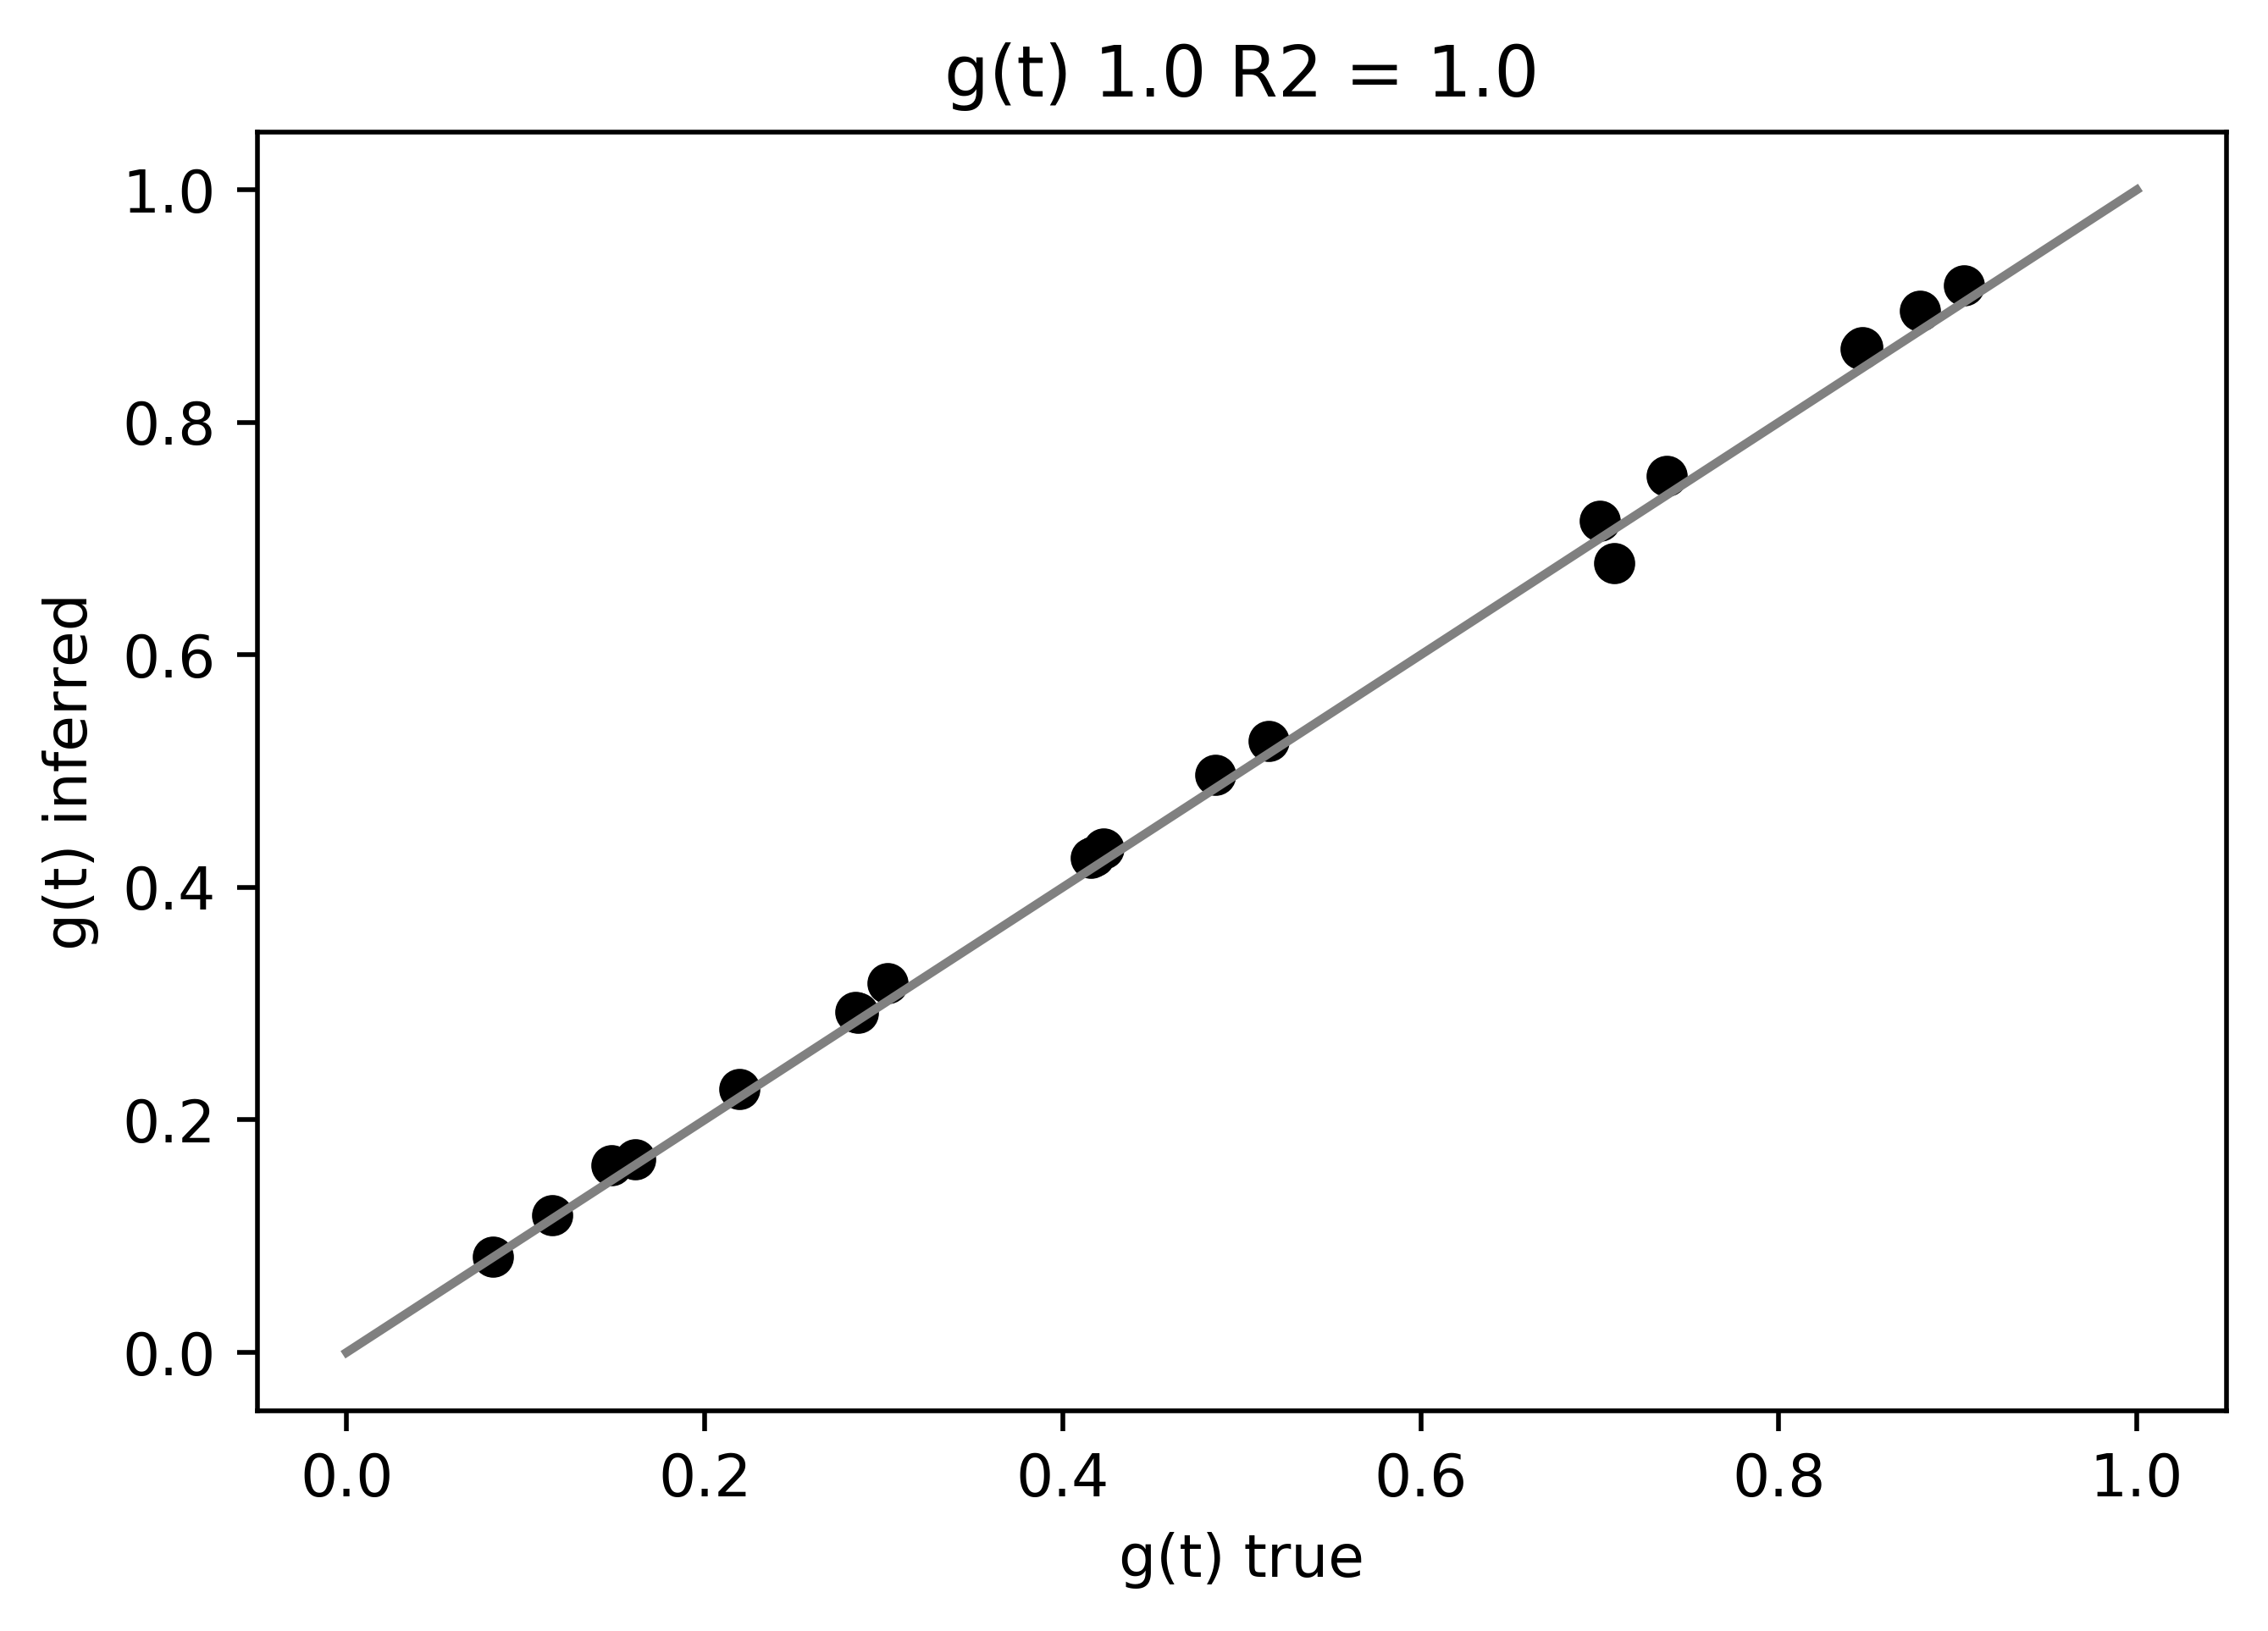

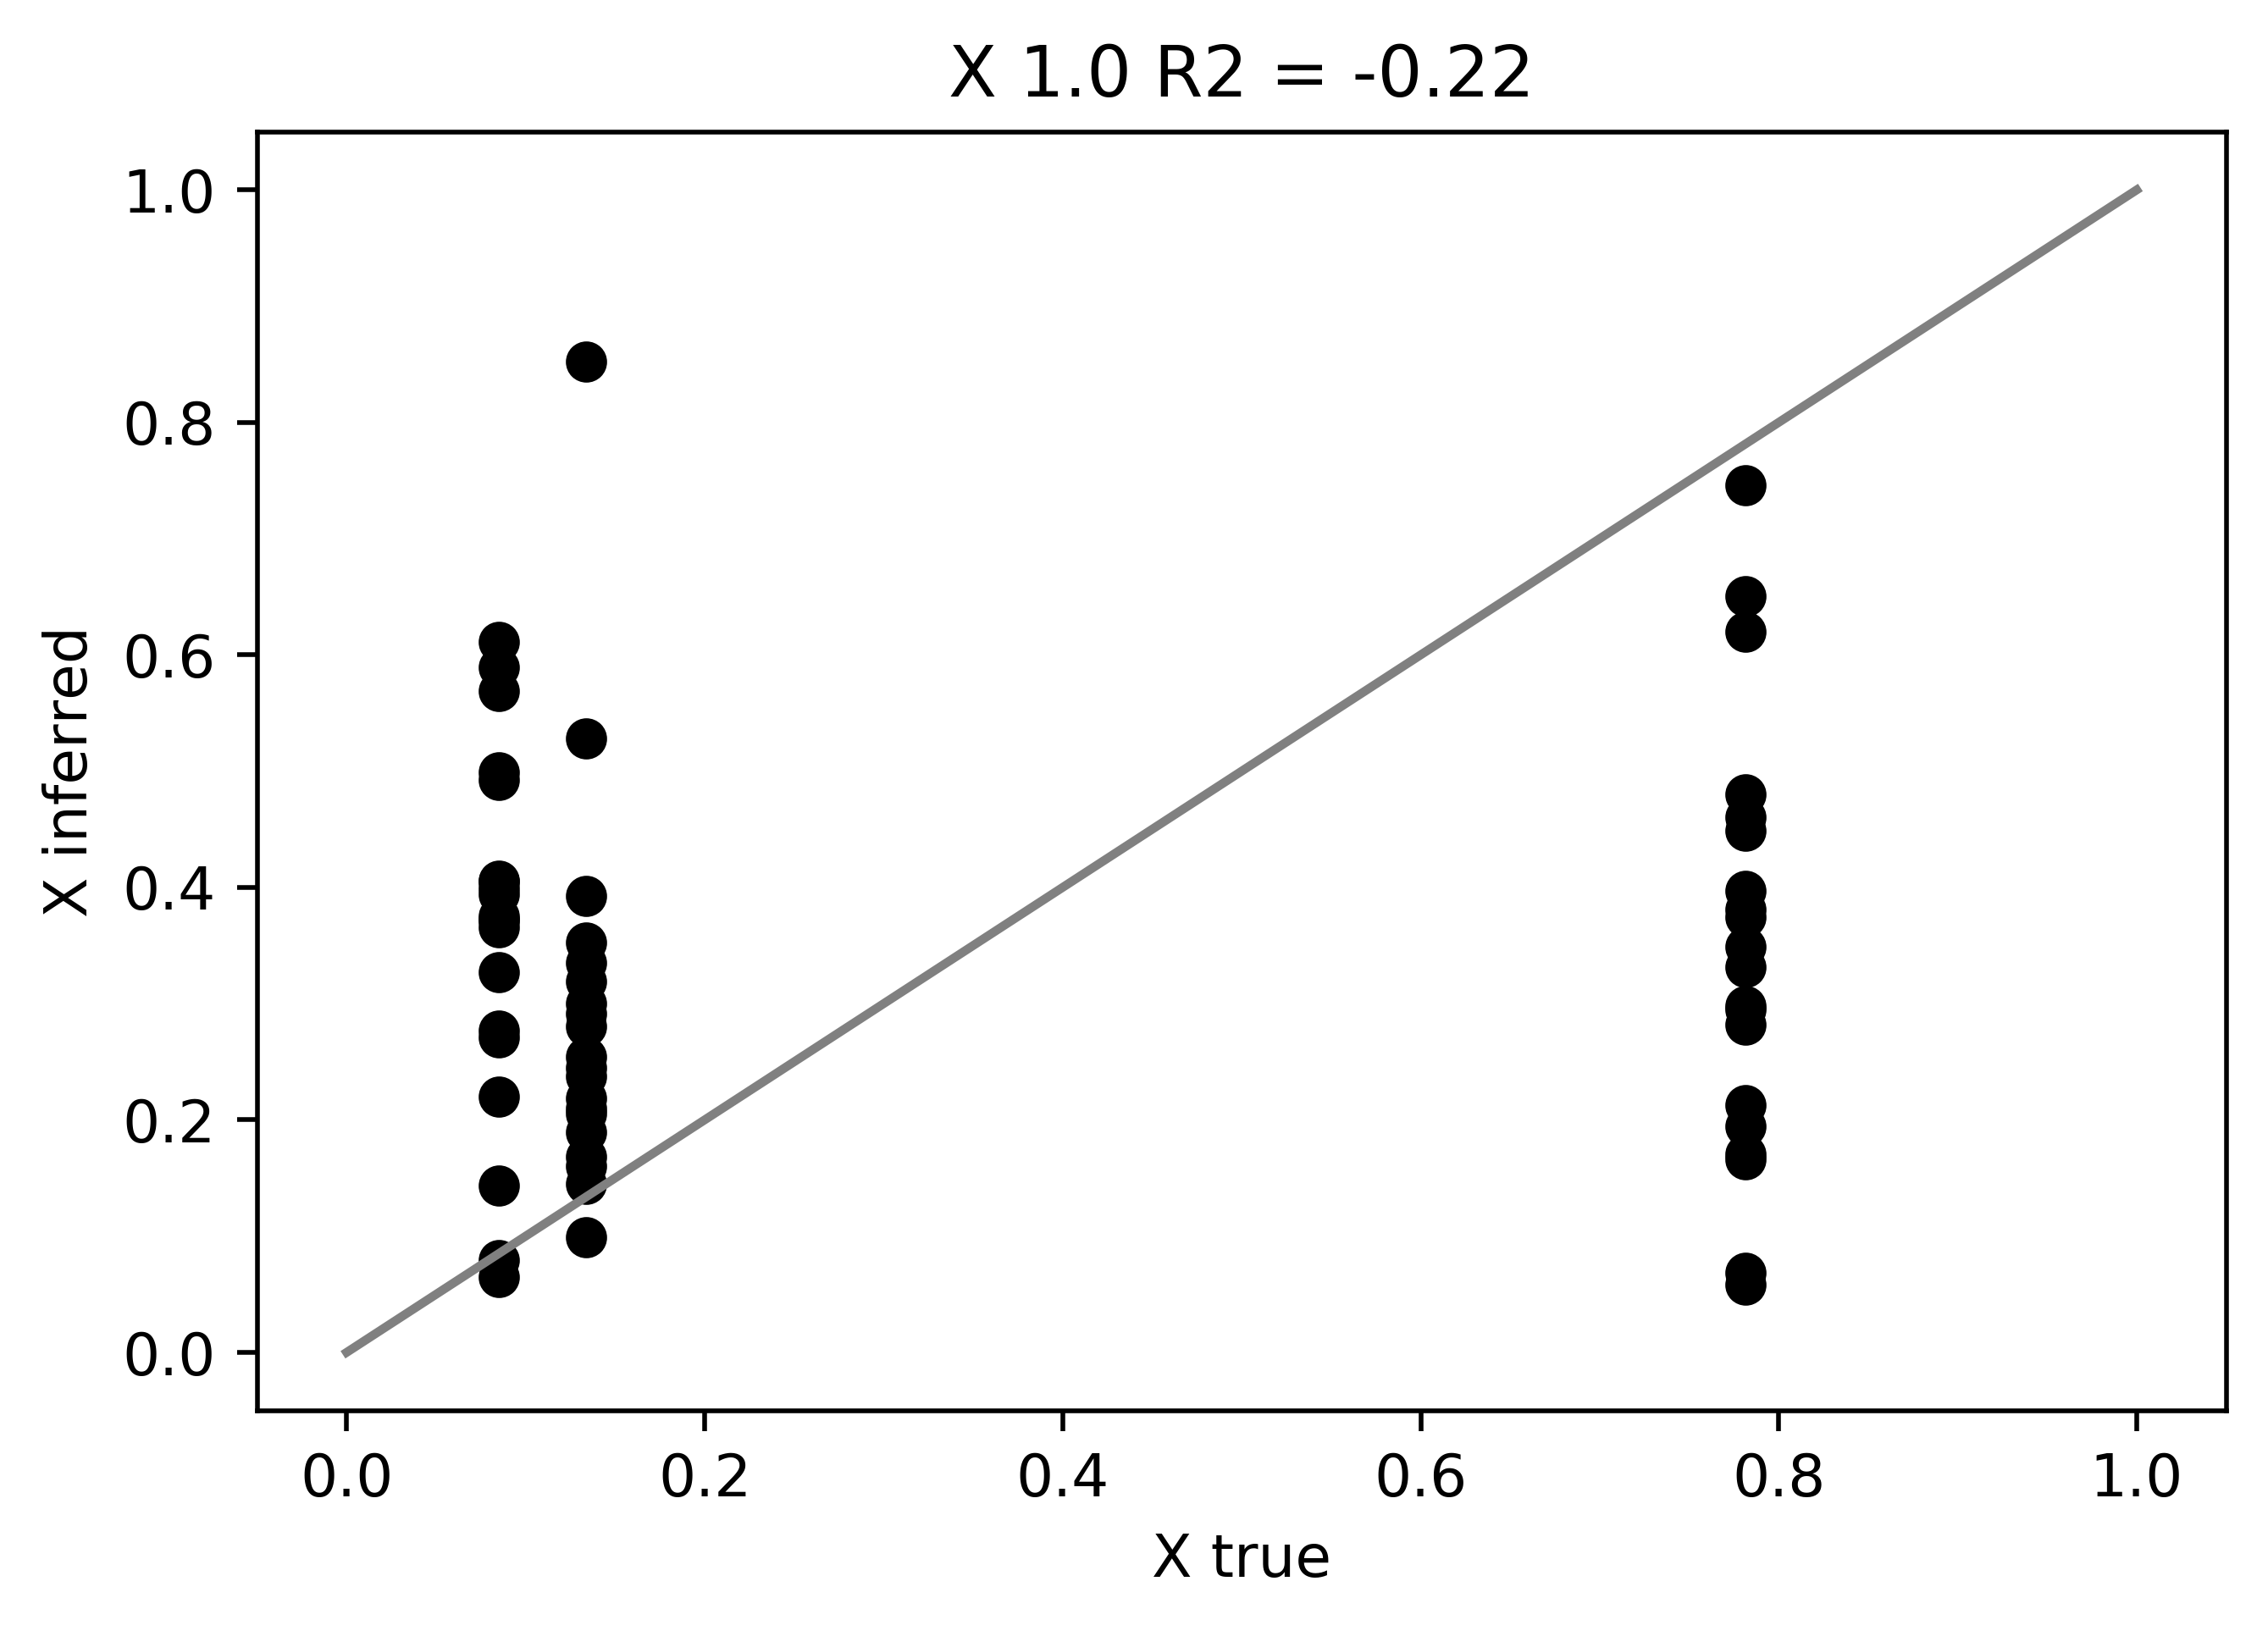

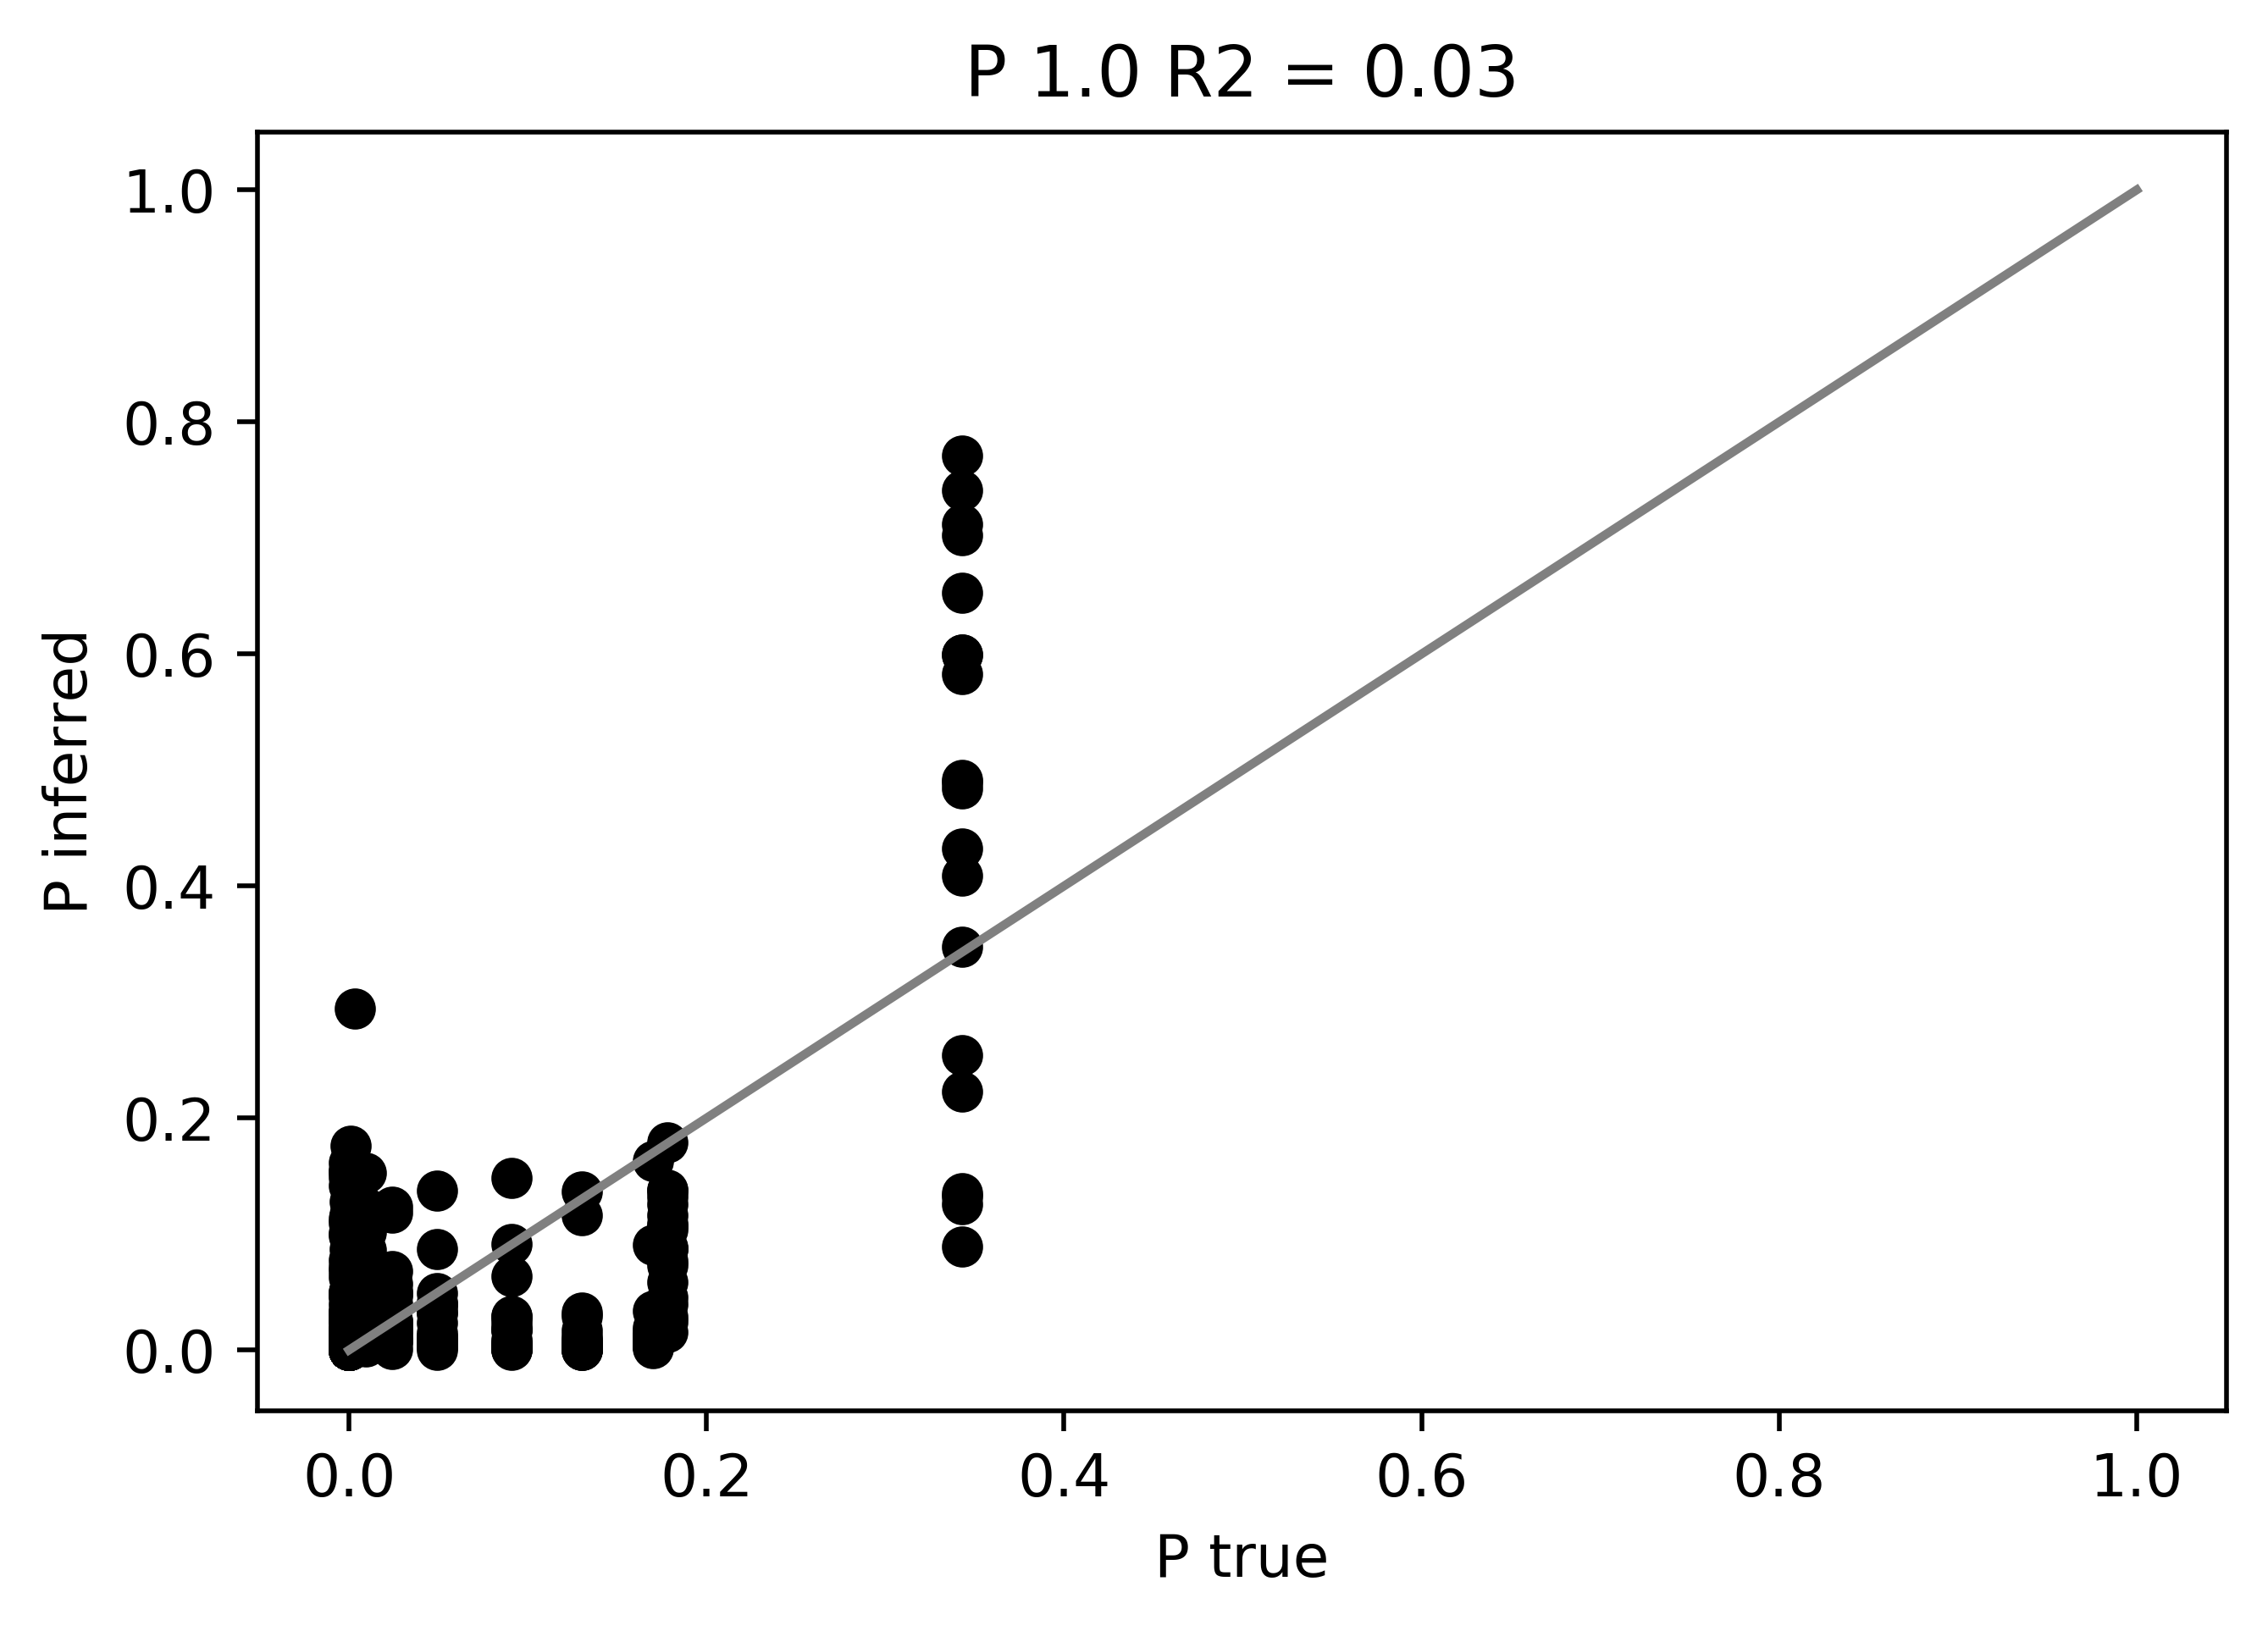

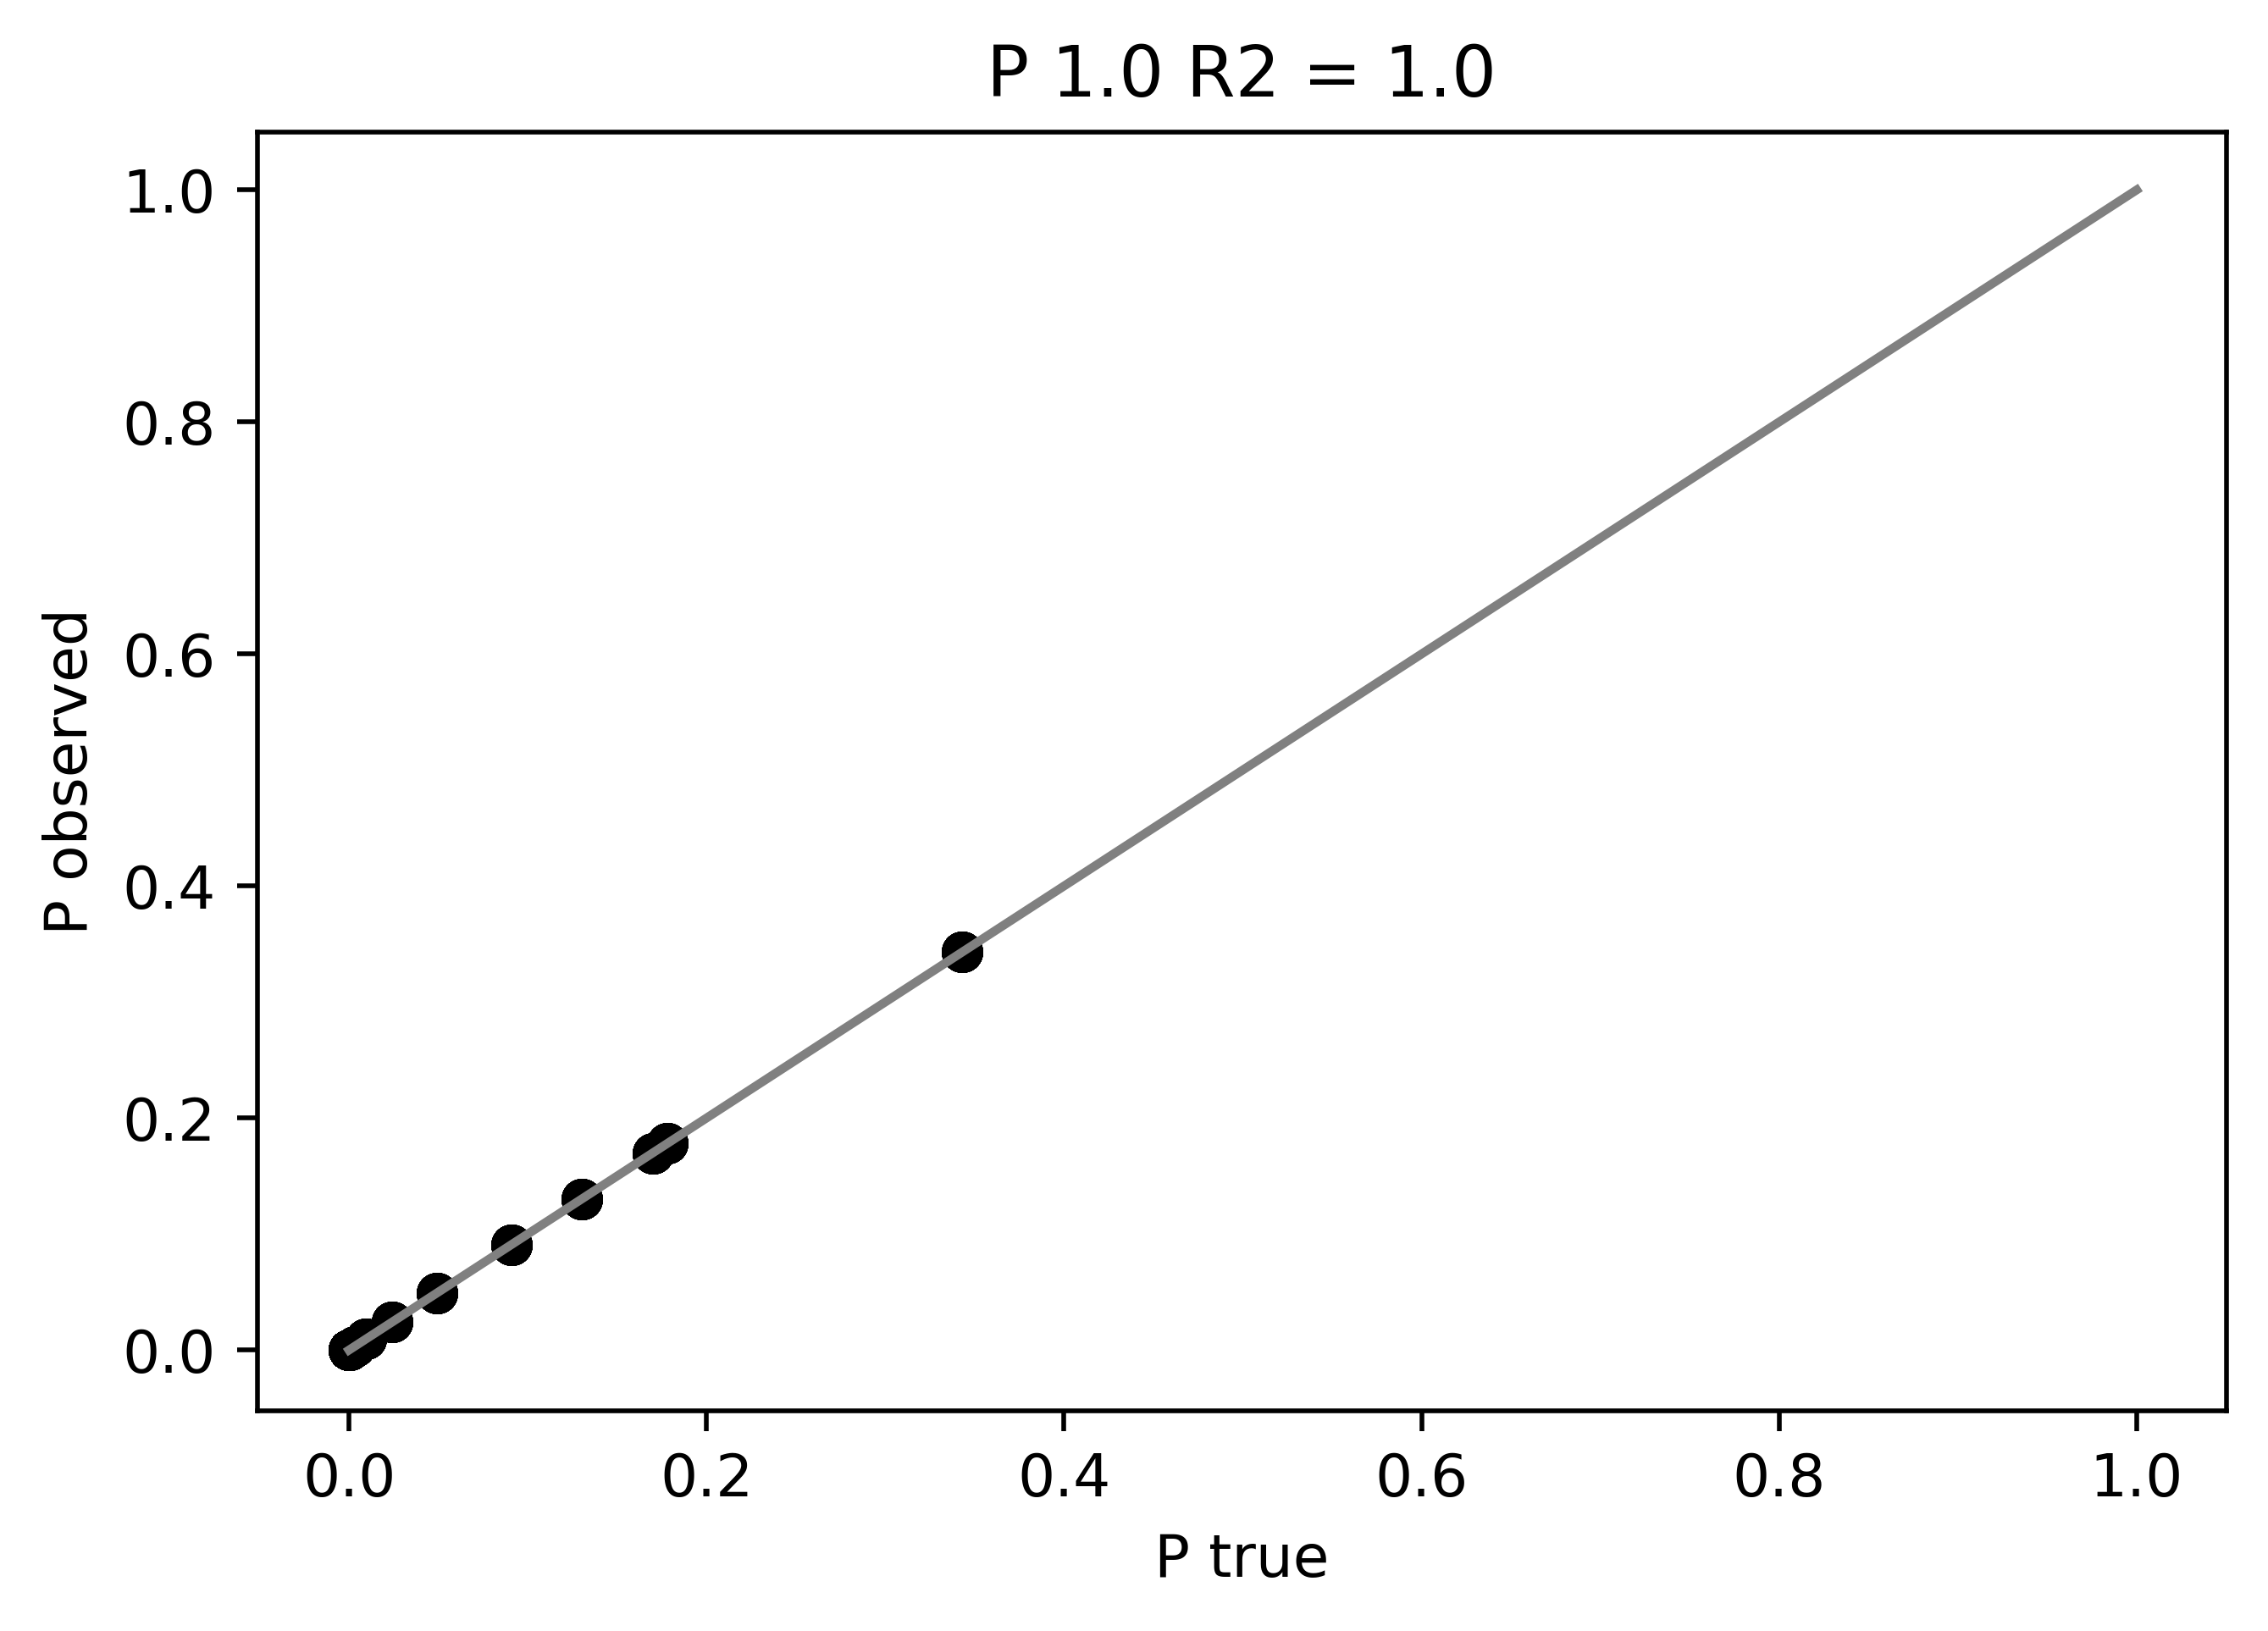

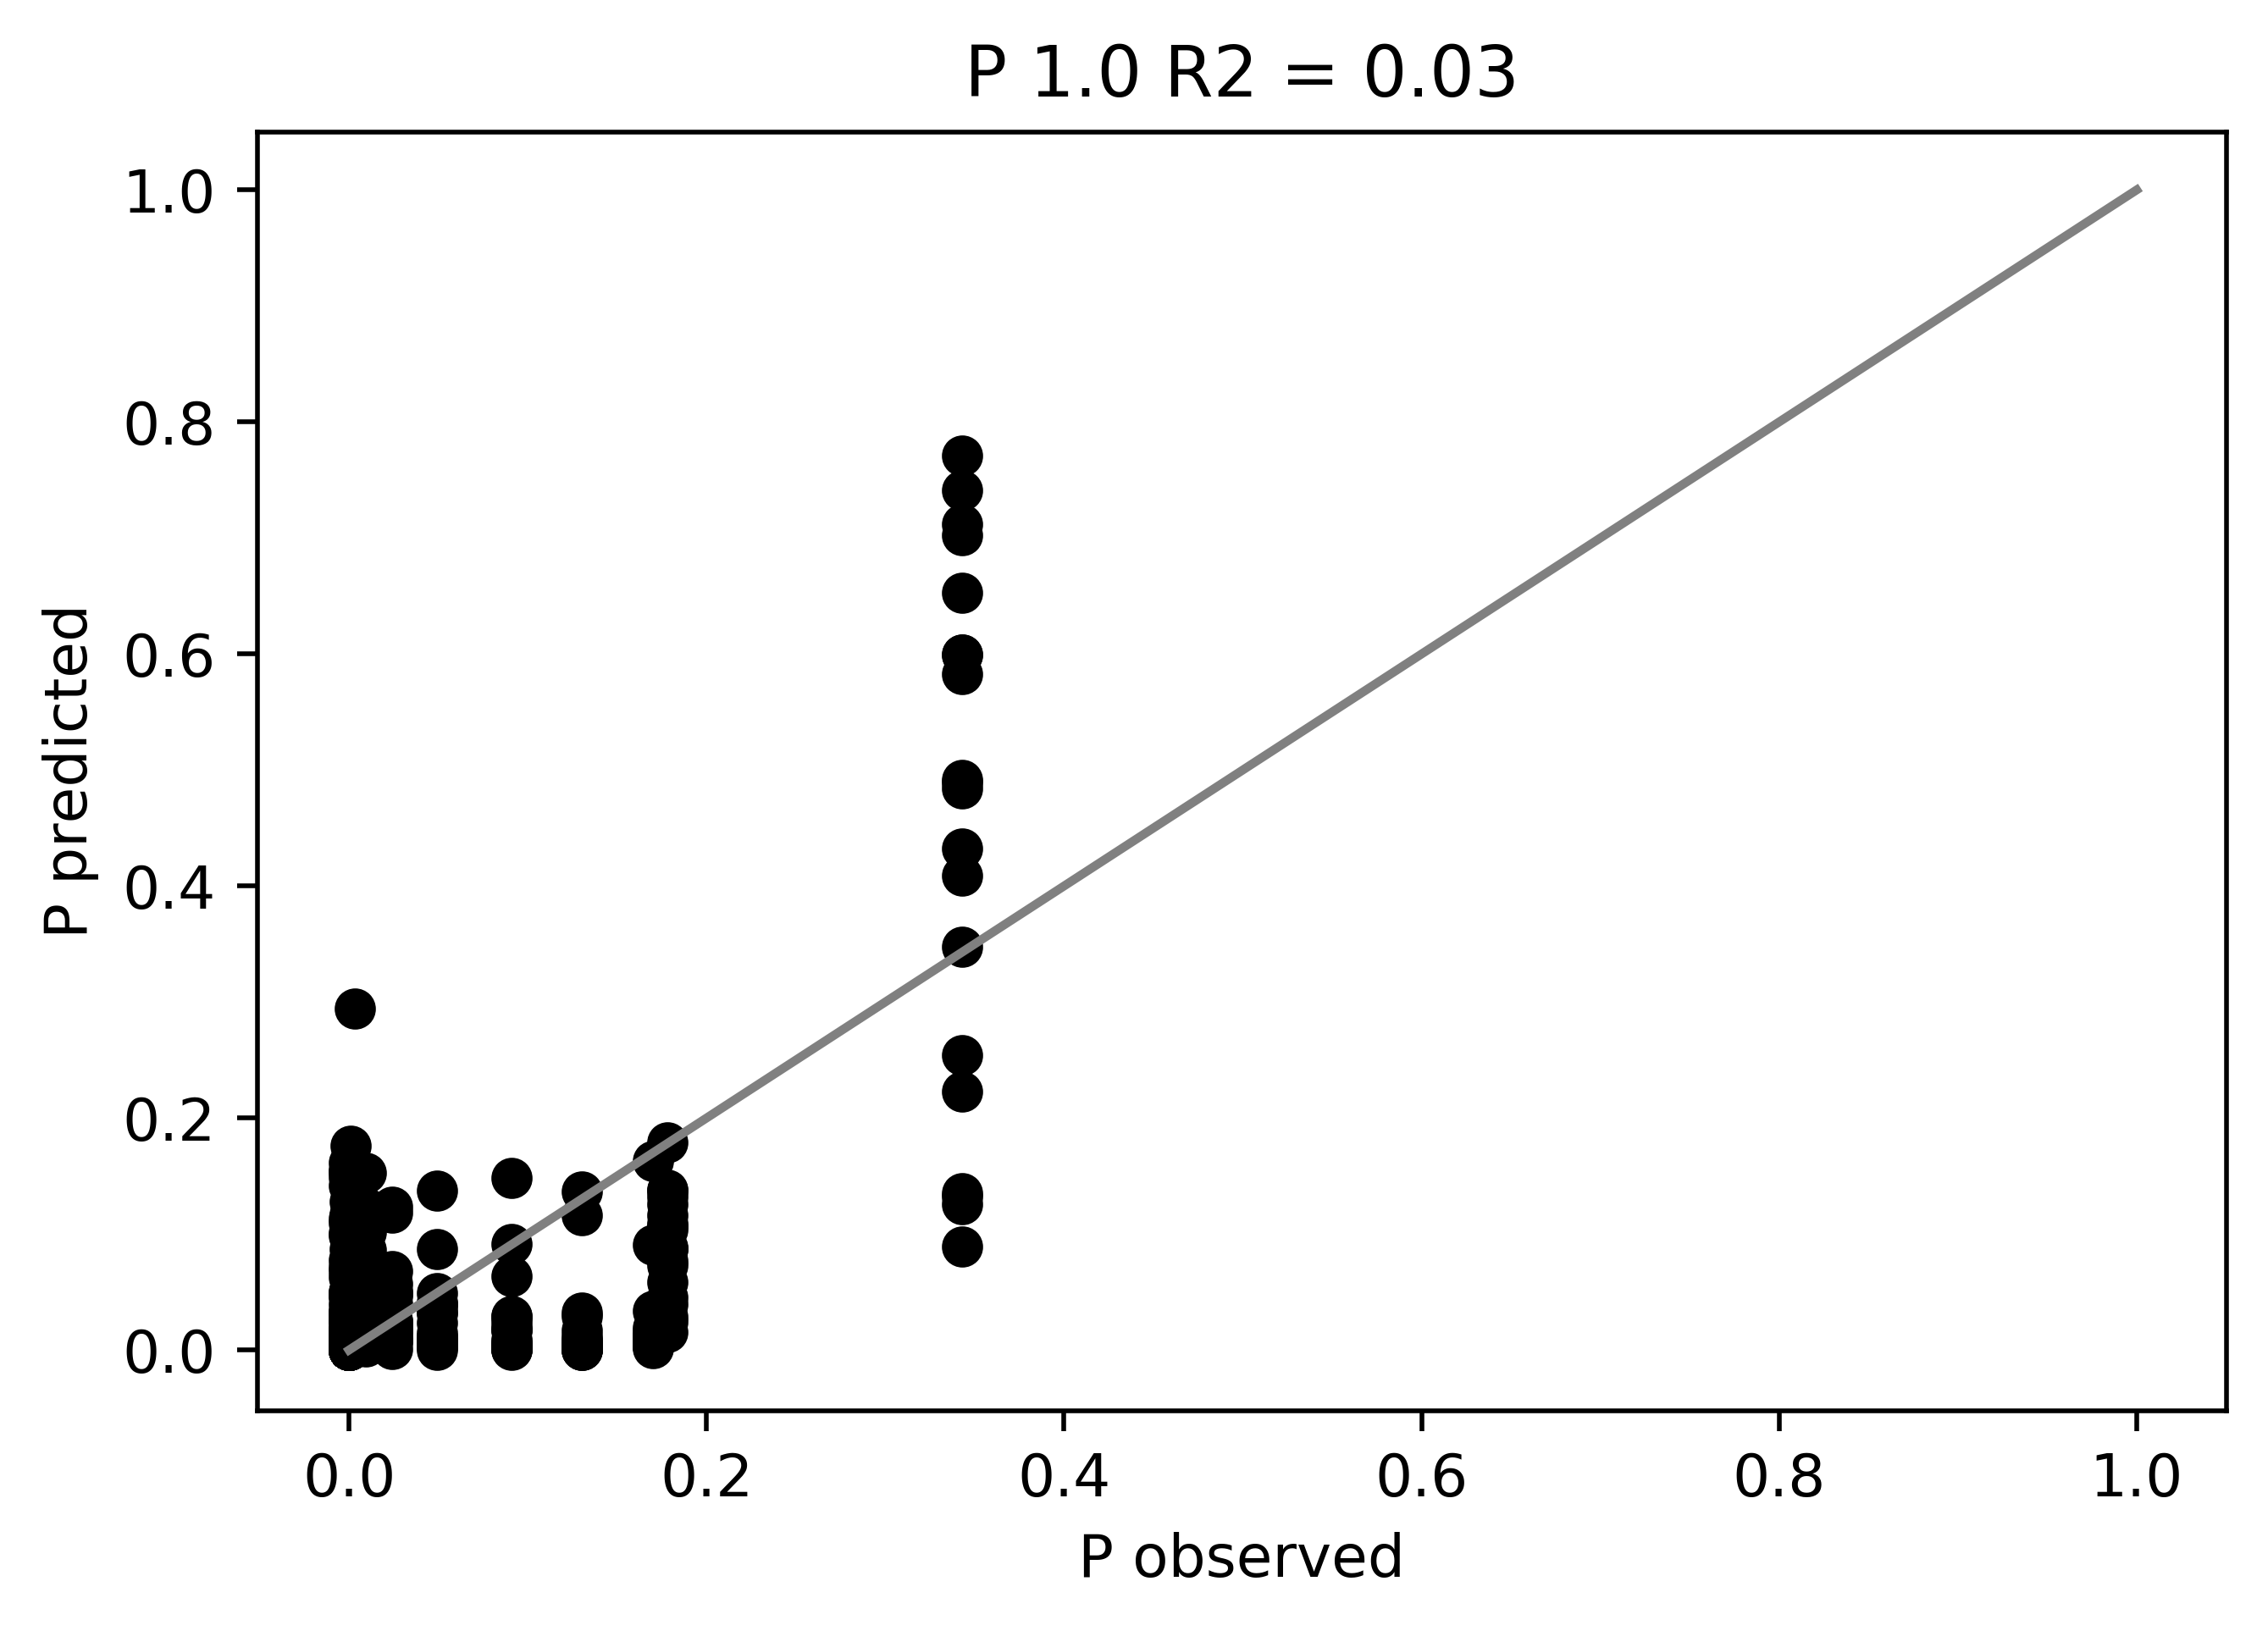

In [12]:

plt.figure()
plt.scatter(gs,g_preds,color="black")
plt.plot([0,1],[0,1],color="grey")
plt.xlabel("g(t) true")
plt.ylabel("g(t) inferred")
plt.title("g(t) " + str(noiseFrac) + " R2 = " + str(np.round(r2_score(gs,g_preds),2)))

plt.figure()
plt.scatter(x_trues,x_preds,color="black")
plt.plot([0,1],[0,1],color="grey")
plt.xlabel("X true")
plt.ylabel("X inferred")
plt.title("X " + str(noiseFrac) + " R2 = " + str(np.round(r2_score(x_trues,x_preds),2)))

plt.figure()
plt.scatter(l_theo,l_preds,color="black")
plt.plot([0,1],[0,1],color="grey")
plt.xlabel("P true")
plt.ylabel("P inferred")
plt.title("P " + str(noiseFrac) + " R2 = " + str(np.round(r2_score(l_theo,l_preds),2)))


plt.figure()
plt.scatter(l_theo,l_observed,color="black")
plt.plot([0,1],[0,1],color="grey")
plt.xlabel("P true")
plt.ylabel("P observed")
plt.title("P " + str(noiseFrac) + " R2 = " + str(np.round(r2_score(l_theo,l_observed),2)))


plt.figure()
plt.scatter(l_observed,l_preds,color="black")
plt.plot([0,1],[0,1],color="grey")
plt.xlabel("P observed")
plt.ylabel("P predicted")
plt.title("P " + str(noiseFrac) + " R2 = " + str(np.round(r2_score(l_observed,l_preds),2)))

In [42]:
print(T,N)



[0, 0, 1] [0.978121, 0.021758, 0.00012099999999999999]
